<b> Use this to show so that the print doen't make the matrix truncuadted </b>

In [1]:
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)

<b> To put back the default use the below code </b>

In [2]:
#np.set_printoptions(edgeitems=3, infstr='inf',
#linewidth=75, nanstr='nan', precision=8,
#suppress=False, threshold=1000, formatter=None)

# Importing libraries

In [3]:
from scipy.interpolate import griddata
import scipy.io
import random 
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import pandas as pd

plt.set_cmap("jet")

<Figure size 432x288 with 0 Axes>

# Loading dataset and related size 

In [4]:
X_test = scipy.io.loadmat('FBH12_WF_unnormal.mat')
Y_test = scipy.io.loadmat('FBH12_Y.mat')
X_test = X_test['DDD'] 
Y_test = Y_test['dd']

In [5]:
X_train = scipy.io.loadmat("Ins12_WF_unnormal.mat")
Y_train = scipy.io.loadmat("MaskIn512.mat")
X_train = X_train['DDD']
Y_train = Y_train['MaskIn']

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(139, 139, 10)
(512, 512)
(115, 113, 10)
(512, 512)


In [7]:
np.count_nonzero(Y_train.flatten()==1)/(512*512)

0.0818939208984375

# The needed functions

<b> labeling prcoess </b>

In [8]:
# cx = [432 429 432 428 180 301 58 56  51  54  180 298];
# cy = [429 293 178 60  48  48  56 167 288 410 403 410];

# MaskIn = np.zeros((512,512));

# for i in range(0:7)
#     MaskIn[cx(i):cx(i)+36,cy(i):cy(i)+36]=1;

# for i = 7:12
#     MaskIn(cx(i):cx(i)+46,cy(i):cy(i)+46)=1;

# plt.imshow(MaskIn)

<b>Max-Min normalization</b>

In [9]:
def E_imagmaxmin(inp):
    [m,n] = np.shape(inp)
    inp = inp.flatten()
    max_inp = np.max(inp)
    min_inp = np.min(inp)
    for ii in range(inp.shape[0]):
        inp[ii] = (inp[ii] - min_inp) / (max_inp-min_inp)  
    inp = np.reshape(inp,[m,n])
    return inp

<b> Interpolation </b>

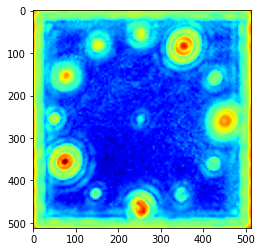

In [10]:
def LI(m,newNumberOfCols,newNumberOfRows):
    [x, y] = np.meshgrid(np.arange(1,m.shape[0]+1,1), np.arange(1,m.shape[0]+1,1))
    tt = np.zeros((m.shape[0]*m.shape[1],2))
    tt[:,0] = x.flatten()
    tt[:,1] = y.flatten()
    [xq, yq] = np.meshgrid(np.linspace(1, m.shape[0], newNumberOfCols), np.linspace(1, m.shape[1], newNumberOfRows));
    grid_z0 = griddata(tt, m.flatten(), (xq, yq), method='linear') 
    return grid_z0

plt.imshow(np.log(LI(X_test[1:114,:,0],512,512)))

<b> padding </b>

In [11]:
def zero_pad(X, pad):
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),mode='constant',constant_values=(0,0))
    return X_pad

<b> Patch Maker </b>

In [12]:
def PatchMaker (X,f,stride,pad,flag):
    if flag==0:    
        X = np.reshape(X,[1,X.shape[0],X.shape[1],X.shape[2]])
        Z=[]
        (m,n_H_prev, n_W_prev) = X.shape[0],X.shape[1],X.shape[2] 
        n_H = int((n_H_prev-f+2*pad)/(stride))+1
        n_W =  int((n_W_prev-f+2*pad)/(stride))+1
        X = zero_pad(X,pad)
        X = X[0,:,:,:]               
        for h in range(n_H):            
            vert_start = h*stride
            vert_end   = h*stride+f       
            for w in range(n_W):          
                horiz_start =  w*stride
                horiz_end   =  w*stride+f          
                Z.append(X[vert_start:vert_end,horiz_start:horiz_end,:])   
        Data = np.zeros([len(Z),Z[0].shape[0],Z[0].shape[1],Z[0].shape[2]], dtype= np.float64)           
        i = 0
        for x in Z:
            Data[i] = x 
            i+=1 
    else:      
        X = np.reshape(X,[1,X.shape[0],X.shape[1],1])
        Z=[]
        (m,n_H_prev, n_W_prev) = X.shape[0],X.shape[1],X.shape[2] 
        n_H = int((n_H_prev-f+2*pad)/(stride))+1
        n_W =  int((n_W_prev-f+2*pad)/(stride))+1
        X = zero_pad(X,pad)
        X = X[0,:,:]               
        for h in range(n_H):            
            vert_start = h*stride
            vert_end   = h*stride+f       
            for w in range(n_W):          
                horiz_start =  w*stride
                horiz_end   =  w*stride+f          
                Z.append(X[vert_start:vert_end,horiz_start:horiz_end,:])   
        Data = np.zeros([len(Z),Z[0].shape[0],Z[0].shape[1],Z[0].shape[2]], dtype= np.float64)             
        i = 0
        for x in Z:
            Data[i] = x 
            i+=1     
    return Data



# example for checking the patch-maker

# CC = PatchMaker (X_train1,64,64,0,0)
# plt.imshow(CC[1,:,:,0])
# print(CC[1,63,63,0])
# print(X_train1[63,127,0])
# del CC

# Rescaling and normalization of training and test data

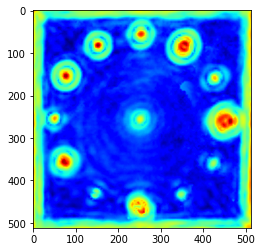

In [13]:
X_train1 = np.zeros((512,512,10))
X_test1  = np.zeros((512,512,10))

for i in range(X_train.shape[2]):
    X_test1  [:,:,i]   = LI(E_imagmaxmin(np.log(X_test[1:114,:,i])),512,512)
    X_train1 [:,:,i]   = LI(E_imagmaxmin(np.log(X_train[:,:,i])),512,512)

    
X_train1.shape
X_test1.shape
plt.imshow(X_test1[:,:,1])

# Visualizing the tonebursts

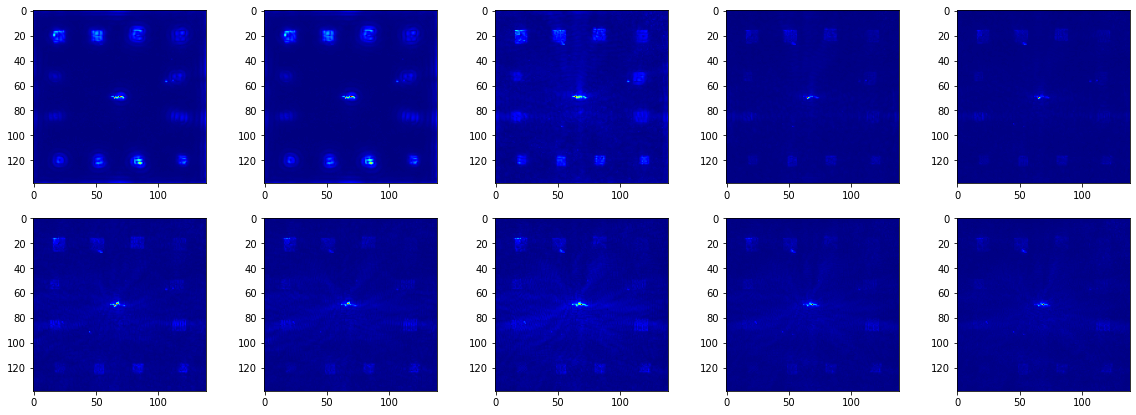

In [19]:
fig = plt.figure(figsize=(20, 7))
col,row = [2,5]
num_im = X_train.shape[2]
for i in range (1,num_im+1):
    fig.add_subplot(col, row, i)
    plt.imshow((X_train[:,:,i-1]))  

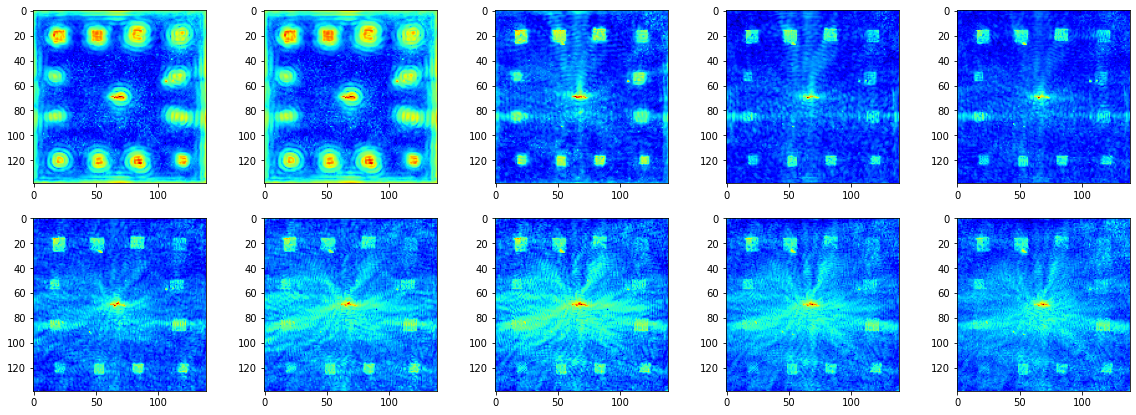

In [16]:
fig = plt.figure(figsize=(20, 7))
col,row = [2,5]
num_im = X_train.shape[2]
for i in range (1,num_im+1):
    fig.add_subplot(col, row, i)
    plt.imshow(np.log(X_train[:,:,i-1]))

<b>Detailed Architecture of Figure 2</b>

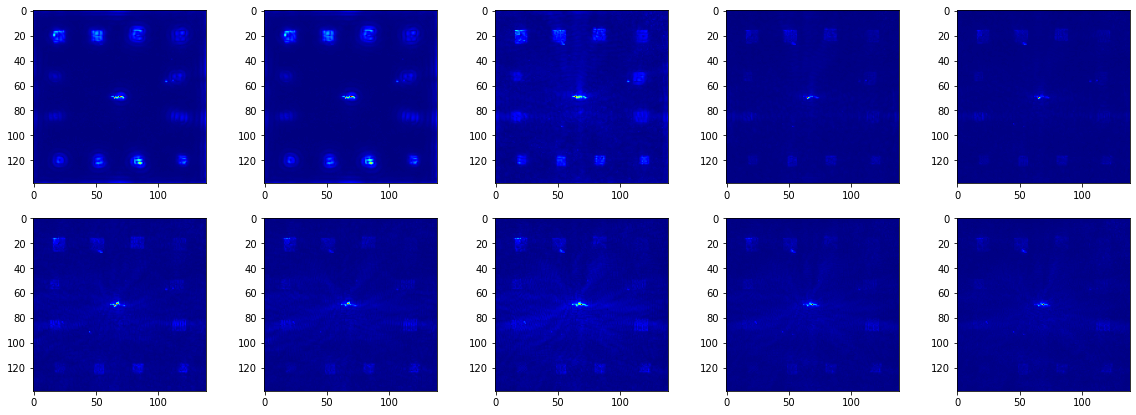

In [17]:
fig = plt.figure(figsize=(20, 7))
col,row = [2,5]
num_im = X_train.shape[2]
for i in range (1,num_im+1):
    fig.add_subplot(col, row, i)
    plt.imshow(E_imagmaxmin(X_train[:,:,i-1]))

C:\Users\Global Village\AppData\Local\Temp\ipykernel_8956\3865168534.py:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(E_imagmaxmin(X_train[:,:,i-1])))


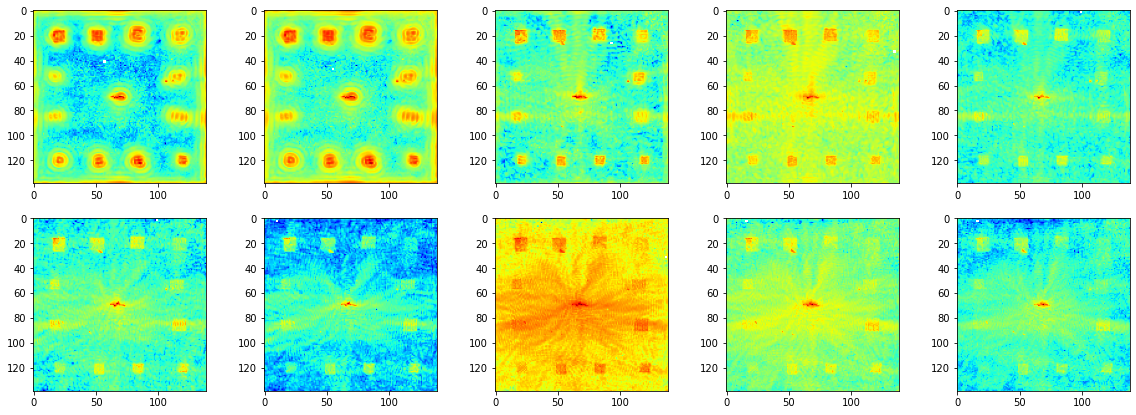

In [18]:
fig = plt.figure(figsize=(20, 7))
col,row = [2,5]
num_im = X_train.shape[2]
for i in range (1,num_im+1):
    fig.add_subplot(col, row, i)
    plt.imshow(np.log(E_imagmaxmin(X_train[:,:,i-1])))

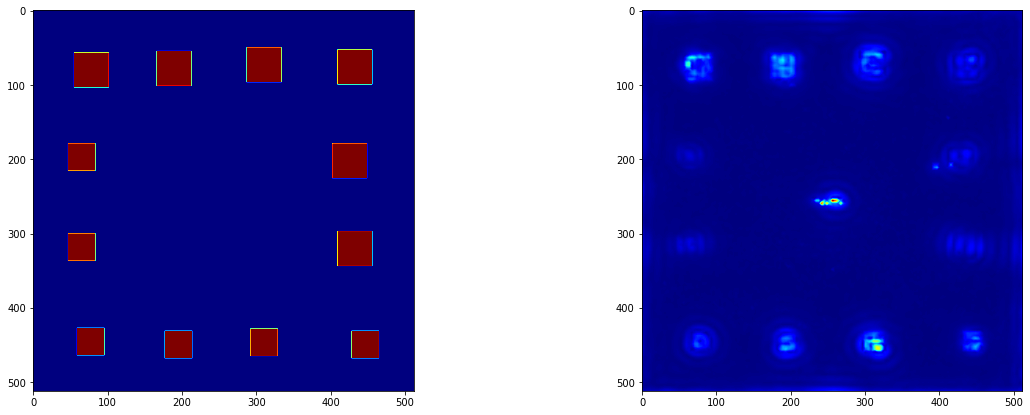

In [19]:
fig = plt.figure(figsize = (20,7))
col,row = [1,2]
fig.add_subplot(col,row,1)
plt.imshow(Y_train)
fig.add_subplot(col,row,2)
plt.imshow(LI(X_train[:,:,0],512,512))

<b>I checked the above picture in matlab and figured out that the labels are chosen with adequate accuracy

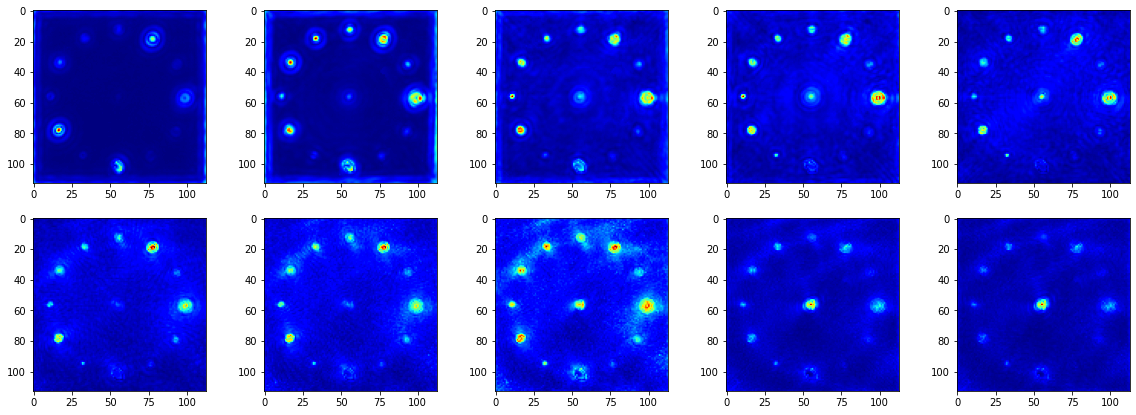

In [20]:
fig = plt.figure(figsize=(20, 7))
col,row = [2,5]
num_im = X_test.shape[2]
for i in range (1,num_im+1):
    fig.add_subplot(col, row, i)
    plt.imshow((X_test[1:114,:,i-1]))  

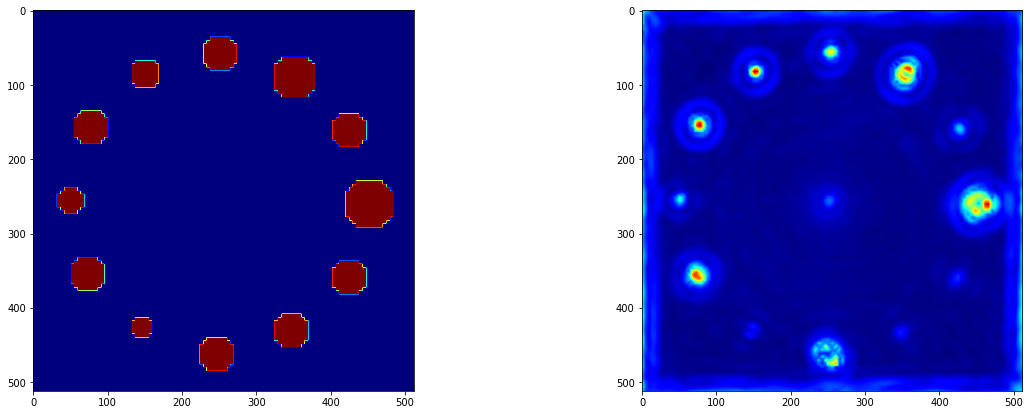

In [21]:
fig = plt.figure(figsize = (20,7))
col,row = [1,2]
fig.add_subplot(col,row,1)
plt.imshow(Y_test)
fig.add_subplot(col,row,2)
plt.imshow(LI(X_test[1:114,:,1],512,512))

# Making Patches

In [20]:
Data_train = PatchMaker(X_train1,64,64,0,0)
Data_test  = PatchMaker(X_test1,64,64,0,0)
print(Data_train.shape)
print(Data_test.shape)

(64, 64, 64, 10)
(64, 64, 64, 10)


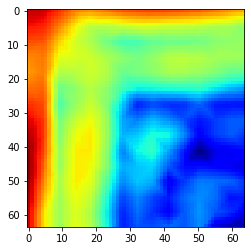

In [21]:
plt.imshow(Data_test[0,:,:,0])

In [24]:
Data_train_y = PatchMaker(Y_train,64,64,0,1)
Data_test_y  = PatchMaker(Y_test,64,64,0,1)

(64, 64, 64, 1)
(64, 64, 64, 1)


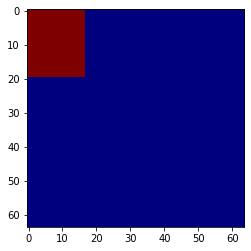

In [25]:
print(Data_train_y.shape)
print(Data_test_y.shape)
plt.imshow(Data_train_y[63,:,:,0])

In [26]:
# del model

NameError: name 'model' is not defined

# Model

<b> Unet Structure </b>

In [27]:
seed = 42
random.seed = seed
np.random.seed = seed



# Build U-Net model
inputs = Input((Data_train.shape[1], Data_train.shape[2], Data_train.shape[3]))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])  # This is related to the skip connection 
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 10)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   1456        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   2320        dropout[0][0]                    
______________________________________________________________________________________________

In [27]:
results = model.fit(Data_train, Data_train_y, batch_size=4, epochs=50)

Epoch 1/50
16/16 [==============================] - 5s 16ms/step - loss: 0.2713 - accuracy: 0.9012
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.2213 - accuracy: 0.9163
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1777 - accuracy: 0.9326
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1432 - accuracy: 0.9472
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1188 - accuracy: 0.9555
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1184 - accuracy: 0.9545
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1044 - accuracy: 0.9615
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1195 - accuracy: 0.9530
Epoch 9/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1057 - accuracy: 0.9590
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1090 - accuracy: 0.9560
Epoch 11/

In [36]:
stride = 64
f      = 64
pad    = 0 
preds_train = model.predict(Data_train, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
DM = np.zeros([512,512],dtype = np.float64)
i = 0
n_H = int((X_train1.shape[0]-f+2*pad)/(stride))+1
n_W =  int((X_train1.shape[1]-f+2*pad)/(stride))+1

for h in range(n_H):            
    vert_start = h*stride
    vert_end   = h*stride+f       
    for w in range(n_W):   
        horiz_start =  w*stride
        horiz_end   =  w*stride+f   
        x = preds_train_t[i,:,:,0]
        DM[vert_start:vert_end,horiz_start:horiz_end] = x 
        i+=1

2/2 [==============================] - 0s 9ms/step


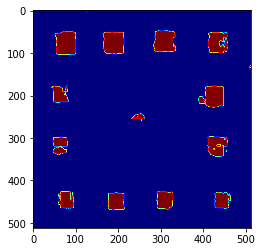

In [37]:
plt.imshow(DM)

In [38]:
preds_test = model.predict(Data_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
DM = np.zeros([512,512],dtype = np.float64)
i = 0
for h in range(n_H):            
    vert_start = h*stride
    vert_end   = h*stride+f       
    for w in range(n_W):   
        horiz_start =  w*stride
        horiz_end   =  w*stride+f   
        x = preds_test[i,:,:,0]
        DM[vert_start:vert_end,horiz_start:horiz_end] = x 
        i+=1

2/2 [==============================] - 0s 9ms/step


<b> Without Treshold </b>

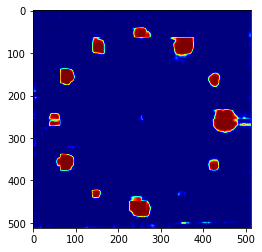

In [44]:
plt.imshow(DM)

<b> Also test with 0.01 where u can see the deepest defect too </b>

In [42]:
# model.save('GWIDA1.h5') 
# model = load_model('GWIDA1.h5')

# Second approach based on  Local patches 

<b> For this study the article regarding toung cancer segmentation

In [39]:
Data_train = PatchMaker(X_train1,64,2,31,0)
Data_train_label = PatchMaker(Y_train,64,2,31,1)

In [40]:
print(Data_train.shape)
print(Data_train_label.shape)
plt.imshow(Data_train_label[1,:,:,:])

(65536, 64, 64, 10)
(65536, 64, 64, 1)


In [42]:
train_y=Data_train_label.reshape(Data_train_label.shape[0],)


ValueError: cannot reshape array of size 268435456 into shape (65536,)

In [ ]:
train_y=train_y.reshape(Data_train.shape[0],)
train_y=pd.Series(train_y)
train_y.value_counts()
a,b=train_y.value_counts()
print(100*(a/(a+b)),': This is the majority class')
print(100*(b/(a+b)),': This is the manority class')
minority_class_len=len(train_y[train_y.values==1])
majority_class_indices=train_y[train_y.values== 0].index
np.random.seed(37)
random_majority_indices=np.random.choice(majority_class_indices,minority_class_len,replace=False)
print(len(random_majority_indices))  
minority_class_indices=train_y[train_y.values==1].index
print(minority_class_indices)
under_sample_indices=np.concatenate([minority_class_indices,random_majority_indices])
under_sample_train_y=train_y.loc[under_sample_indices]
under_sample_train_y.value_counts()  
under_sample_train_y=under_sample_train_y.values

under_sample_train_x=np.zeros((270,7,7,3001,1))
for i in range(train_x.shape[3]) :
    for j in range(7):
        for jj in range(7):
            under_sample_train_x[:,j,jj,i,0]=pd.Series(train_x[:,j,jj,i,0]).loc[under_sample_indices]
under_sample_train_x.shape

under_sample_train_y=under_sample_train_y.reshape(270,1)
np.save('under_sample_train_x.npy',under_sample_train_x)
np.save('under_sample_train_y.npy',under_sample_train_y)

under_sample_indices[135]
train_y[355]
np.all(under_sample_train_x[135,:,:,:,0]==train_x[355,:,:,:,0]) # cecking for an non defect 


# In[3]:


train_y=train_y.reshape(train_y.shape[0],)
train_y=pd.Series(train_y)
train_y.value_counts()
a,b=train_y.value_counts()
print(100*(a/(a+b)),': This is the majority class')
print(100*(b/(a+b)),': This is the manority class')
minority_class_len=len(train_y[train_y.values==1])
majority_class_indices=train_y[train_y.values== 0].index
np.random.seed(37)
random_majority_indices=np.random.choice(majority_class_indices,minority_class_len,replace=False)
print(len(random_majority_indices))  
minority_class_indices=train_y[train_y.values==1].index
print(minority_class_indices)
under_sample_indices=np.concatenate([minority_class_indices,random_majority_indices])
under_sample_train_y=train_y.loc[under_sample_indices]
under_sample_train_y.value_counts()  
under_sample_train_y=under_sample_train_y.values

under_sample_train_x=np.zeros((270,7,7,3001,1))
for i in range(train_x.shape[3]) :
    for j in range(7):
        for jj in range(7):
            under_sample_train_x[:,j,jj,i,0]=pd.Series(train_x[:,j,jj,i,0]).loc[under_sample_indices]
under_sample_train_x.shape

under_sample_train_y=under_sample_train_y.reshape(270,1)
np.save('under_sample_train_x_normalized.npy',under_sample_train_x)
np.save('under_sample_train_y_normalized.npy',under_sample_train_y)

under_sample_indices[135]
train_y[355]
np.all(under_sample_train_x[135,:,:,:,0]==train_x[355,:,:,:,0]) # cecking for an non defect 


# # Library
